# Deep Fusion Project

Liming Zhao, Jingdong Wang, Xi Li, Zhuowen Tu, and Wenjun Zeng. "On the Connection of Deep Fusion to Ensembling." arXiv preprint arXiv:1611.07718 (2016).

Table of Contents:
0. Overview of training
0. Define the network symbol
0. Load dataset
0. Tran the model
0. Show the results

Please see https://github.com/dmlc/mxnet for more tutorials about MXNet.

## 1. Overview of using the training code

In [1]:
import mxnet as mx
#my own code
import options
import train_model

In [2]:
argv = ['--network=cross', '--depth=26', '--dataset=cifar10',
        '--data-dir=../../../dataset/cifar10/', '--gpus=2,3', 
        '--num-epochs=5', '--log-iters=250'] #just for demo
args = options.get_args(argv)

2016-11-25 10:31:02,548 ./snapshot/cifar10/cross/cross_d26w1_exp3.txt
2016-11-25 10:31:02,549 start with arguments Namespace(aug_type=1, batch_size=64, checkpoint_epochs=0, data_dir='../../../dataset/cifar10/', data_shape=32, dataset='cifar10', depth=26, exp_name=None, gpus='2,3', kv_store='device', load_epoch=None, log_dir='./snapshot/cifar10/', log_iters=250, lr=0.1, lr_factor=0.1, lr_steps=None, mean_rgb=[125.307, 122.95, 113.865], model_args={}, model_prefix='./snapshot/cifar10/cross/weights/cross_d26w1_exp3/cross_d26w1_exp3', network='cross', num_classes=10, num_epochs=5, num_examples=50000, rand_seed=1480041062, std_rgb=[62.993, 62.089, 66.705], test_batch_size=400, train_dataset='train.rec', val_dataset='test.rec', widen_factor=1)
2016-11-25 10:31:02,594 Using gpus 2,3 from:
GPU 0: Tesla K40m (UUID: GPU-0bd915e7-a296-e3cc-57b7-6ff90229911e)
GPU 1: Tesla K40m (UUID: GPU-8e74496b-98bb-1381-524c-dfb9ad86ad22)
GPU 2: Tesla K40m (UUID: GPU-f7a80203-0ce2-380c-a34a-eedb5d5c1360)
GPU 3:

In [3]:
#the following Sections 2,3,4 are actually what the train_model.train() function will do
#Logging format: process N images per second, loss (average loss), top1 acc % (average top1 acc %)
train_model.train(args)

2016-11-25 10:31:02,635 network parameters: 0.3494M
2016-11-25 10:31:04,612 Start training with [gpu(0), gpu(1)]
2016-11-25 10:31:30,312 Epoch[0] Batch [250]	Speed: 1237	loss: 1.7268(1.7268)	top1: 35.9875(35.9875)
2016-11-25 10:31:43,437 Epoch[0] Batch [500]	Speed: 1219	loss: 1.3148(1.5208)	top1: 52.2312(44.1094)
2016-11-25 10:31:55,183 Epoch[0] Batch [750]	Speed: 1362	loss: 1.1172(1.3862)	top1: 59.9125(49.3771)
2016-11-25 10:31:56,846 Epoch[0] Resetting Data Iterator
2016-11-25 10:31:56,848 Epoch[0] Time cost=39.776
2016-11-25 10:31:56,937 Saved checkpoint to "./snapshot/cifar10/cross/weights/cross_d26w1_exp3/cross_d26w1_exp3-0001.params"
2016-11-25 10:31:57,391 Epoch[0] Validation-cross-entropy=1.558810
2016-11-25 10:31:57,392 Epoch[0] Validation-accuracy=0.420000
2016-11-25 10:32:10,068 Epoch[1] Batch [250]	Speed: 1270	loss: 1.0047(1.0047)	top1: 64.1875(64.1875)
2016-11-25 10:32:22,428 Epoch[1] Batch [500]	Speed: 1294	loss: 0.9245(0.9646)	top1: 67.1937(65.6906)
2016-11-25 10:32:35,3

## 2. Define the network symbol

In [1]:
import mxnet as mx
from network.base import FuseNet
from show_model import show_net

In [2]:
#define another inception-like net for demo
class ThreeNet(FuseNet):
    def __init__(self, *args, **kwargs):
        FuseNet.__init__(self, *args, **kwargs)
        self.set_blocks(block_depth=4)
    #different network has different fusion module
    def get_fusion(self, name, data, kin, kout):
        line = self.get_zero(name+'_b0', data, kin, kout)
        branch1 = self.get_two(name+'_b1', data, kin, kout)
        branch2 = self.get_two(name+'_b2', data, kin, kout)
        branch3 = self.get_two(name+'_b3', data, kin, kout)
        #resnet style: identity + two convs
        data = line+branch1+branch2+branch3
        data = mx.symbol.Activation(name=name+'_relu', data=data, act_type='relu')
        return data

In [3]:
three_net=ThreeNet(num_classes=10,num_depth=14, widen_factor=1)
three_net_symbol=three_net.get_symbol()

In [32]:
import mxnet as mx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_image(file_name):
    plt.figure(figsize=(8,8))
    plt.axis('off')
    from PIL import Image
    img=Image.open(file_name)
    plt.imshow(img)

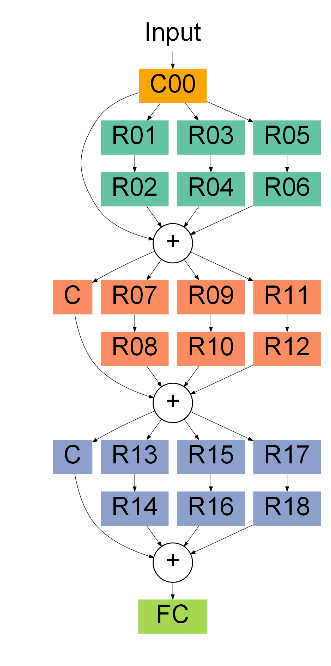

In [33]:
image_name=show_net(net=three_net_symbol,name='three_net_d14')
show_image(image_name)

## 3. Load the dataset

In [48]:
batch_size=128

def get_iterator(data_dir):
    data_iter = mx.io.ImageRecordIter(
        data_shape=(3, 32, 32),
        path_imgrec = data_dir,
        batch_size=batch_size,
    )
    return data_iter

(128L, 3L, 32L, 32L) (128L,)
(3L, 32L, 32L) 1.0


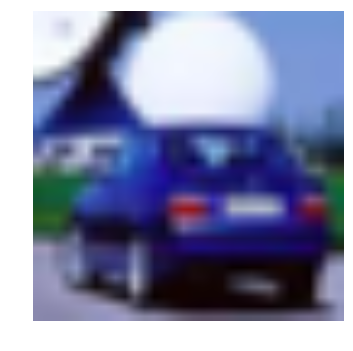

In [49]:
train_data=get_iterator(data_dir='../../../dataset/cifar10/train.rec')
test_data=get_iterator(data_dir='../../../dataset/cifar10/test.rec')

for dbatch in train_data:
    data =dbatch.data[0].asnumpy()
    label = dbatch.label[0].asnumpy()
    print data.shape,label.shape
    idx=np.random.randint(0,data.shape[0]) #show the one image of current batch
    image=np.uint8(np.squeeze(data[idx,:]))
    image_label=label[idx]
    print image.shape,image_label
    plt.figure();plt.axis('off');
    plt.imshow(image.transpose(1,2,0));plt.show()
    break

## 4. Tran the model

In [10]:
#model
model = mx.model.FeedForward(
    ctx=[mx.gpu(0),mx.gpu(1)],
    symbol=three_net_symbol,
    num_epoch=2, #run only 2 epochs for demo
    learning_rate=0.1,
    momentum=0.9,
    wd=0.0001,
    optimizer='nag',
    initializer=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2),
)

model.fit(X=train_data,eval_data=test_data,
          batch_end_callback=mx.callback.Speedometer(batch_size,50))

2016-11-25 10:34:41,217 Start training with [gpu(0), gpu(1)]
2016-11-25 10:34:45,381 Epoch[0] Batch [50]	Speed: 1855.07 samples/sec	Train-accuracy=0.319063
2016-11-25 10:34:48,855 Epoch[0] Batch [100]	Speed: 1843.85 samples/sec	Train-accuracy=0.450313
2016-11-25 10:34:52,612 Epoch[0] Batch [150]	Speed: 1703.49 samples/sec	Train-accuracy=0.498281
2016-11-25 10:34:56,404 Epoch[0] Batch [200]	Speed: 1689.10 samples/sec	Train-accuracy=0.550937
2016-11-25 10:34:59,970 Epoch[0] Batch [250]	Speed: 1796.24 samples/sec	Train-accuracy=0.578125
2016-11-25 10:35:03,581 Epoch[0] Batch [300]	Speed: 1773.84 samples/sec	Train-accuracy=0.598281
2016-11-25 10:35:07,260 Epoch[0] Batch [350]	Speed: 1740.08 samples/sec	Train-accuracy=0.617656
2016-11-25 10:35:10,223 Epoch[0] Resetting Data Iterator
2016-11-25 10:35:10,226 Epoch[0] Time cost=28.522
2016-11-25 10:35:11,400 Epoch[0] Validation-accuracy=0.375000
2016-11-25 10:35:14,904 Epoch[1] Batch [50]	Speed: 1856.15 samples/sec	Train-accuracy=0.648594
2016

## 4. Show the results and training curves (TODO)